<a href="https://colab.research.google.com/github/tago893/Algoproject-TSP/blob/main/Project_f__real_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Analysis of TSP Algorithms

## Introduction
This notebook presents a comparative analysis of three algorithms used to solve the Traveling Salesman Problem (TSP): Christofides, Nearest Neighbor, and Lin-Kernighan. We aim to assess their efficiency, accuracy, and applicability to different datasets.


In [480]:
import pandas as pd # for data manipulation
import numpy as np # for linear algebra
import plotly.express as px # for
import matplotlib.pyplot as plt # for plotting
import time # for time

In [481]:
# Getting path of dataset
dataset_path = "/content/worldcities.csv"
# Loading specific columns from dataset
df = pd.read_csv(dataset_path, usecols=["country", "city", "population", "lat", "lng"])

# Displaying our data
df.head()

,city,lat,lng,country,population
0,Tokyo,35.6897,139.6922,Japan,37732000.0
1,Jakarta,-6.1750,106.8275,Indonesia,33756000.0
2,Delhi,28.6100,77.2300,India,32226000.0
3,Guangzhou,23.1300,113.2600,China,26940000.0
4,Mumbai,19.0761,72.8775,India,24973000.0


Please change the country name to which ever country you like to make the algorithms find optimal path for

In [482]:
# Filtering only US cities
data = df.loc[df['country'] == 'Australia', ["country", "city", "population", "lat", "lng"]]
# Printing us data
data.head()

,country,city,population,lat,lng
147,Australia,Sydney,4840600.0,-33.8678,151.2100
158,Australia,Melbourne,4529500.0,-37.8142,144.9631
358,Australia,Brisbane,2360241.0,-27.4678,153.0281
388,Australia,Perth,2141834.0,-31.9559,115.8606
589,Australia,Adelaide,1295714.0,-34.9275,138.6000


In [483]:
# Filtering cities that have higher population than median
high_pop_data = data[data['population'] > data['population'].median()]

# Remaining data for medium and low population clusters
remaining_data = data[data['population'] <= data['population'].median()]

# Splitting high population data into high and medium population clusters
high_pop_cluster = high_pop_data.iloc[:int(len(high_pop_data) * 0.3)].reset_index(drop=True)
medium_pop_cluster = high_pop_data.iloc[int(len(high_pop_data) * 0.3):].reset_index(drop=True)

# Concatenating remaining data with medium population data for the medium population cluster
medium_pop_cluster = pd.concat([medium_pop_cluster, remaining_data.iloc[:int(len(remaining_data) * 0.2)]], ignore_index=True)

# The remaining data goes to the low population cluster
low_pop_cluster = remaining_data.iloc[int(len(remaining_data) * 0.2):].reset_index(drop=True)

In [484]:
info_to_work_on=input("please enter which type of populated cities you want to the algorithms analyze on(high,medium,low): ")

please enter which type of populated cities you want to the algorithms analyze on(high,medium,low): high


In [485]:
if info_to_work_on == "high":
  data = high_pop_cluster
elif info_to_work_on == "medium":
  data = medium_pop_cluster
elif info_to_work_on == "low":
  data = low_pop_cluster

In [486]:
# Creating a scatter plot using Plotly
fig1 = px.scatter_mapbox(data, lat="lat", lon="lng", hover_name="city", zoom=3, height=600, size_max=8)

# Customizing the map style
fig1.update_layout(mapbox_style="carto-positron")

# Showing the interactive plot
fig1.show()

In [487]:
# Selecting data from a dataframe
cities_coordinates = data.loc[:,['lat', 'lng']].to_numpy()

# Selecting names of cities from dataframe
cities_names = data.loc[:,['city']].to_numpy()

# Printing first 10 rows of cities_coordinates
cities_coordinates[:10]

array([[-33.8678, 151.21  ],
       [-37.8142, 144.9631],
       [-27.4678, 153.0281],
       [-31.9559, 115.8606],
       [-34.9275, 138.6   ],
       [-35.2931, 149.1269],
       [-28.0167, 153.4   ],
       [-38.0996, 145.2834],
       [-33.3   , 151.2   ],
       [-34.4331, 150.8831]])

In [488]:
# Getting first row
first_city = cities_coordinates[0,:]
first_name = cities_names[0,:]

# Printing first row
first_city
first_name

array(['Sydney'], dtype=object)

In [489]:
!pip install python_tsp

In [490]:
from python_tsp.distances import great_circle_distance_matrix

# Creating distance matrix containing distance from each point to another
distance_matrix = great_circle_distance_matrix(cities_coordinates)

# Printing distance_matrix and its dimensions
print("matrix dimensions:", distance_matrix.shape,"\n")
print(np.round(distance_matrix[:8,:8]))

matrix dimensions: (40, 40) 

[[      0.  713588.  732540. 3290504. 1162182.  247955.  683257.  710890.]
 [ 713588.       0. 1374807. 2721300.  653686.  465653. 1342885.   42376.]
 [ 732540. 1374807.       0. 3606405. 1600946.  945420.   71167. 1384979.]
 [3290504. 2721300. 3606405.       0. 2130881. 3087928. 3623917. 2752157.]
 [1162182.  653686. 1600946. 2130881.       0.  957967. 1597657.  693385.]
 [ 247955.  465653.  945420. 3087928.  957967.       0.  904287.  463396.]
 [ 683257. 1342885.   71167. 3623917. 1597657.  904287.       0. 1351127.]
 [ 710890.   42376. 1384979. 2752157.  693385.  463396. 1351127.       0.]]


In [491]:
# Checking the number of identical records
data.duplicated().sum()

0

## Algorithm Overview

### Christofides Algorithm
An approximation algorithm providing a solution within 1.5 times the optimal length for metric spaces.

### Nearest Neighbor Algorithm
A greedy approach that builds a tour by selecting the closest unvisited city at each step.

### Lin-Kernighan Heuristic
A heuristic optimization method that iteratively improves the solution by edge swapping.


##Nearest neighbor

In [492]:
# Nearest Neighbor Algorithm
def run_nearest_neighbor_algorithm(distances, start_index=0):
    start_time = time.time()

    current_index = start_index
    unvisited = set(range(len(cities_coordinates)))
    unvisited.remove(current_index)
    path = [current_index]
    total_distance = 0

    while unvisited:
        nearest_index = min(unvisited, key=lambda city: distances[current_index][city])
        total_distance += distances[current_index][nearest_index]
        path.append(nearest_index)
        unvisited.remove(nearest_index)
        current_index = nearest_index

    total_distance += distances[path[-1]][start_index]
    path.append(start_index)

    end_time = time.time()
    execution_time = end_time - start_time
    print("Nearest Neighbor Algorithm Execution Time: {:.2f} seconds".format(execution_time))
    return path, total_distance, execution_time

tour_nn, distance_nn, nn_execution_time = run_nearest_neighbor_algorithm(distance_matrix)
print("Distance of path in kilometers =", np.round(distance_nn/1000, 2))

Nearest Neighbor Algorithm Execution Time: 0.00 seconds
Distance of path in kilometers = 13501.23


##Christofides

In [493]:
import math
import networkx as nx
def calculate_distance(city1, city2):
    lat1, lng1 = city1.lat, city1.lng
    lat2, lng2 = city2.lat, city2.lng
    return math.sqrt((lat2 - lat1)**2 + (lng2 - lng1)**2)

def create_graph(data):
    G = nx.Graph()
    index_map = {row_index: i for i, row_index in enumerate(data.index)}  # Mapping original index to sequential
    for i, city1 in enumerate(data.itertuples()):
        for j, city2 in enumerate(data.itertuples()):
            if i != j:
                distance = calculate_distance(city1, city2)
                G.add_edge(i, j, weight=distance)
    return G, index_map

def eulerian_tour(G):
    return list(nx.eulerian_circuit(G))

def calculate_path_distance(tour, distances):
    total_distance = 0
    for i in range(len(tour) - 1):
        total_distance += distances[tour[i]][tour[i+1]]
    total_distance += distances[tour[-1]][tour[0]]
    return total_distance

def eulerian_to_hamiltonian_tour(eulerian_tour):
    hamiltonian_tour = []
    for edge in eulerian_tour:
        if edge[0] not in hamiltonian_tour:
            hamiltonian_tour.append(edge[0])
    hamiltonian_tour.append(hamiltonian_tour[0])  # Return to the starting city
    return hamiltonian_tour

def christofides_tsp(data):
    start_time = time.time()
    G, index_map = create_graph(data)
    T = nx.minimum_spanning_tree(G)
    odd_degree_nodes = [i for i in T.nodes if T.degree(i) % 2 == 1]
    matching = nx.max_weight_matching(G.subgraph(odd_degree_nodes), maxcardinality=True)
    M = nx.MultiGraph(T)
    M.add_edges_from(matching)
    euler_tour = eulerian_tour(M)
    hamilton_tour = eulerian_to_hamiltonian_tour(euler_tour)
    # Invert the index_map here:
    inverse_index_map = {v: k for k, v in index_map.items()}
    # Use the inverted index map to convert back to original indices
    total_distance = calculate_path_distance(hamilton_tour, distance_matrix)

    execution_time = time.time() - start_time
    print("Christofides Algorithm Execution Time: {:.2f} seconds".format(execution_time))

    return [inverse_index_map[i] for i in hamilton_tour],total_distance, execution_time # Convert back to original indices


tour_ch, christofides_distance,ch_execution_time = christofides_tsp(data)
print("Christofides Tour:")
for idx in tour_ch:
    # Print the city name for each index in the tour
    print(data.iloc[idx]["city"])

Christofides Algorithm Execution Time: 0.09 seconds
Christofides Tour:
Sydney
Central Coast
Newcastle
Port Macquarie
Gold Coast
Corinda
Brisbane
Ballarat
Bendigo
Campbelltown
Orange
Dubbo
Melton
Sunbury
Melbourne
Dandenong
Cranbourne
Frankston
Geraldton
Perth
Adelaide
Leopold
Geelong
Toowoomba
Ipswich
Caloundra
Hervey Bay
Bundaberg
Gladstone
Mackay
Townsville
Cairns
Darwin
Hobart
Launceston
Pakenham
Bunbury
Wagga Wagga
Canberra
Wollongong
Sydney


## Lin Kernighan




In [494]:
def calculate_path_distance(path, distances):
    total_distance = 0
    for i in range(len(path) - 1):
        total_distance += distances[path[i], path[i + 1]]
    return total_distance

def reverse_subsequence(tour, start_index, end_index):
    tour[start_index:end_index + 1] = tour[start_index:end_index + 1][::-1]
def lin_kernighan(tour, distances):
    start_time = time.time()

    best_tour = tour[:]
    best_cost = calculate_path_distance(best_tour, distances)

    while True:
        best_swap = None
        for i in range(len(tour)):
            for j in range(2, len(tour)):
                new_tour = best_tour[:]
                reverse_subsequence(new_tour, i, j)
                new_cost = calculate_path_distance(new_tour + [new_tour[0]], distance_matrix)
                if new_cost < best_cost:
                    best_swap = (i, j)
                    best_cost = new_cost

        if best_swap is None:
            break
        else:
            reverse_subsequence(best_tour, best_swap[0], best_swap[1])

    execution_time = time.time() - start_time
    print("Lin-Kernighan Algorithm Execution Time: {:.2f} seconds".format(execution_time))
    return best_tour , best_cost, execution_time
initial_tour = tour_ch
tour_lk_WL, total_distance_lin_kernighan,lk_execution_time_custom = lin_kernighan(initial_tour, distance_matrix)
print("Distance of path in kilometers =", np.round(total_distance_lin_kernighan/1000, 2))

Lin-Kernighan Algorithm Execution Time: 0.80 seconds
Distance of path in kilometers = 12465.41



###Library implementation


In [495]:
from python_tsp.heuristics import solve_tsp_lin_kernighan
start_time = time.time()
tour_LK, LK_distance = solve_tsp_lin_kernighan(distance_matrix,tour_ch[:-1])
lk_execution_time_lib = time.time() - start_time
print("Lin-Kernighan Algorithm Execution Time: {:.2f} seconds".format(lk_execution_time_lib))
print("Distance of path in kilometers =", np.round(LK_distance/1000, 2))

Lin-Kernighan Algorithm Execution Time: 0.01 seconds
Distance of path in kilometers = 13395.23


## Plots


In [496]:
!pip install plotly
import plotly.graph_objects as go

###CHRISTOFIDES PLOT

In [497]:
import plotly.express as px
import plotly.graph_objects as go

# `best_path` contains the indices of cities in the best path
best_path_indices = tour_ch
best_path_indices = [i % len(data) for i in best_path_indices]
best_path_coordinates = [(data.iloc[idx]["lat"], data.iloc[idx]["lng"]) for idx in best_path_indices]

# Creating a scatter plot using Plotly
fig2 = px.scatter_mapbox(data, lat="lat", lon="lng", hover_name="city", zoom=3, height=600, size_max=8)

# Adding the best path or solution as a line
fig2.add_trace(go.Scattermapbox(
    lat=[coord[0] for coord in best_path_coordinates],
    lon=[coord[1] for coord in best_path_coordinates],
    mode='markers+lines',
    name='Best Path',
    marker=go.scattermapbox.Marker(size=4),
    line=go.scattermapbox.Line(width=1, color='steelblue'),
    text=[data.iloc[idx]["city"] for idx in tour_ch],
))

# Customizing the map style
fig2.update_layout(mapbox_style="carto-positron",title="Best path by christofides algorithm")

# Showing the interactive plot
fig2.show()
print("Execution time is:")
print(ch_execution_time)
print("Distance is:")
print(christofides_distance)

Execution time is:
0.08934521675109863
Distance is:
25198520.432865772


###LIN KERNIGHAN WITHOUT LIBRARY CODE PLOT

In [498]:
import plotly.express as px
import plotly.graph_objects as go

# `best_path` contains the indices of cities in the best path
best_path_indices = tour_lk_WL
best_path_indices = [i % len(data) for i in best_path_indices]
best_path_coordinates = [(data.iloc[idx]["lat"], data.iloc[idx]["lng"]) for idx in best_path_indices]

# Creating a scatter plot using Plotly
fig2 = px.scatter_mapbox(data, lat="lat", lon="lng", hover_name="city", zoom=3, height=600, size_max=8)

# Adding the best path or solution as a line
fig2.add_trace(go.Scattermapbox(
    lat=[coord[0] for coord in best_path_coordinates],
    lon=[coord[1] for coord in best_path_coordinates],
    mode='markers+lines',
    name='Best Path',
    marker=go.scattermapbox.Marker(size=4),
    line=go.scattermapbox.Line(width=1, color='steelblue'),
    text=[data.iloc[idx]["city"] for idx in tour_lk_WL],
))

# Customizing the map style
fig2.update_layout(mapbox_style="carto-positron",title="Best path by lin kernighan algorithm without library")

# Showing the interactive plot
fig2.show()
print("Execution time is:")
print(lk_execution_time_custom)
print("Distance is:")
print(total_distance_lin_kernighan)

Execution time is:
0.8016269207000732
Distance is:
12465409.412453061


###LIN KERNIGHAN LIBRARY PLOT

In [499]:
import plotly.graph_objects as go
import pandas as pd
# Rotate the tour to start and end at the first city
start_index = tour_LK.index(0)
rotated_permutation = tour_LK[start_index:] + tour_LK[:start_index] + [tour_LK[start_index]]
tour_lk = cities_coordinates[rotated_permutation]

fig2 = px.scatter_mapbox(data, lat="lat", lon="lng", hover_name="city", zoom=3, height=600, size_max=8)

# Adding the best path or solution as a line
fig2.add_trace(go.Scattermapbox(
    lat=tour_lk[:, 0],
    lon=tour_lk[:, 1],
    mode='markers+lines',
    name='Best Path',
    marker=go.scattermapbox.Marker(size=4),
    line=go.scattermapbox.Line(width=1,color='steelblue'),))

# Customizibg the map style
fig2.update_layout(mapbox_style="carto-positron",title="Best path by lin kernighan algorithm")


# Showing the interactive plot
fig2.show()

print("Execution time is:")
print(lk_execution_time_lib)
print("Distance is:")
print(LK_distance)

Execution time is:
0.0063936710357666016
Distance is:
13395228.08227162


In [500]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming `best_path` contains the indices of cities in the best path
best_path_indices = tour_nn  # Assuming `tour` contains the indices of cities in the best pa
best_path_indices = [i % len(data) for i in best_path_indices]
best_path_coordinates = [(data.iloc[idx]["lat"], data.iloc[idx]["lng"]) for idx in best_path_indices]

# Creating a scatter plot using Plotly
fig2 = px.scatter_mapbox(data, lat="lat", lon="lng", hover_name="city", zoom=3, height=600, size_max=8)

# Adding the best path or solution as a line
fig2.add_trace(go.Scattermapbox(
    lat=[coord[0] for coord in best_path_coordinates],
    lon=[coord[1] for coord in best_path_coordinates],
    mode='markers+lines',
    name='Best Path',
    marker=go.scattermapbox.Marker(size=4),
    line=go.scattermapbox.Line(width=1, color='steelblue'),
    text=[data.iloc[idx]["city"] for idx in tour_nn],
))

# Customizing the map style
fig2.update_layout(mapbox_style="carto-positron",title="Best path by Nearest neighbor algorithm")

# Showing the interactive plot
fig2.show()

print("Execution time is:")
print(nn_execution_time)
print("Distance is:")
print(distance_nn)

Execution time is:
0.0005955696105957031
Distance is:
13501231.219921868


###Distances and times found

In [501]:
# Executing algorithms and measuring execution times
execution_times = [nn_execution_time, ch_execution_time, lk_execution_time_lib, lk_execution_time_custom]
distances = [distance_nn, christofides_distance, total_distance_lin_kernighan]
algorithms = ["Nearest Neighbor", "Christofides", "Lin-Kernighan library ", "Lin kernighan custom "]

# Create a dictionary to store algorithm names and execution times
algorithm_exec_times = dict(zip(algorithms, execution_times))
algorithm_distances = dict(zip(algorithms, distances))
# Print algorithm and execution time
print("Execution times:")
for algorithm, time in algorithm_exec_times.items():
    print(f"{algorithm}: {time:.2f} seconds")


print("Distances:")
for algorithm, distance in algorithm_distances.items():
    print(f"{algorithm}: {distance} ")

Execution times:
Nearest Neighbor: 0.00 seconds
Christofides: 0.09 seconds
Lin-Kernighan library : 0.01 seconds
Lin kernighan custom : 0.80 seconds
Distances:
Nearest Neighbor: 13501231.219921868 
Christofides: 25198520.432865772 
Lin-Kernighan library : 12465409.412453061 


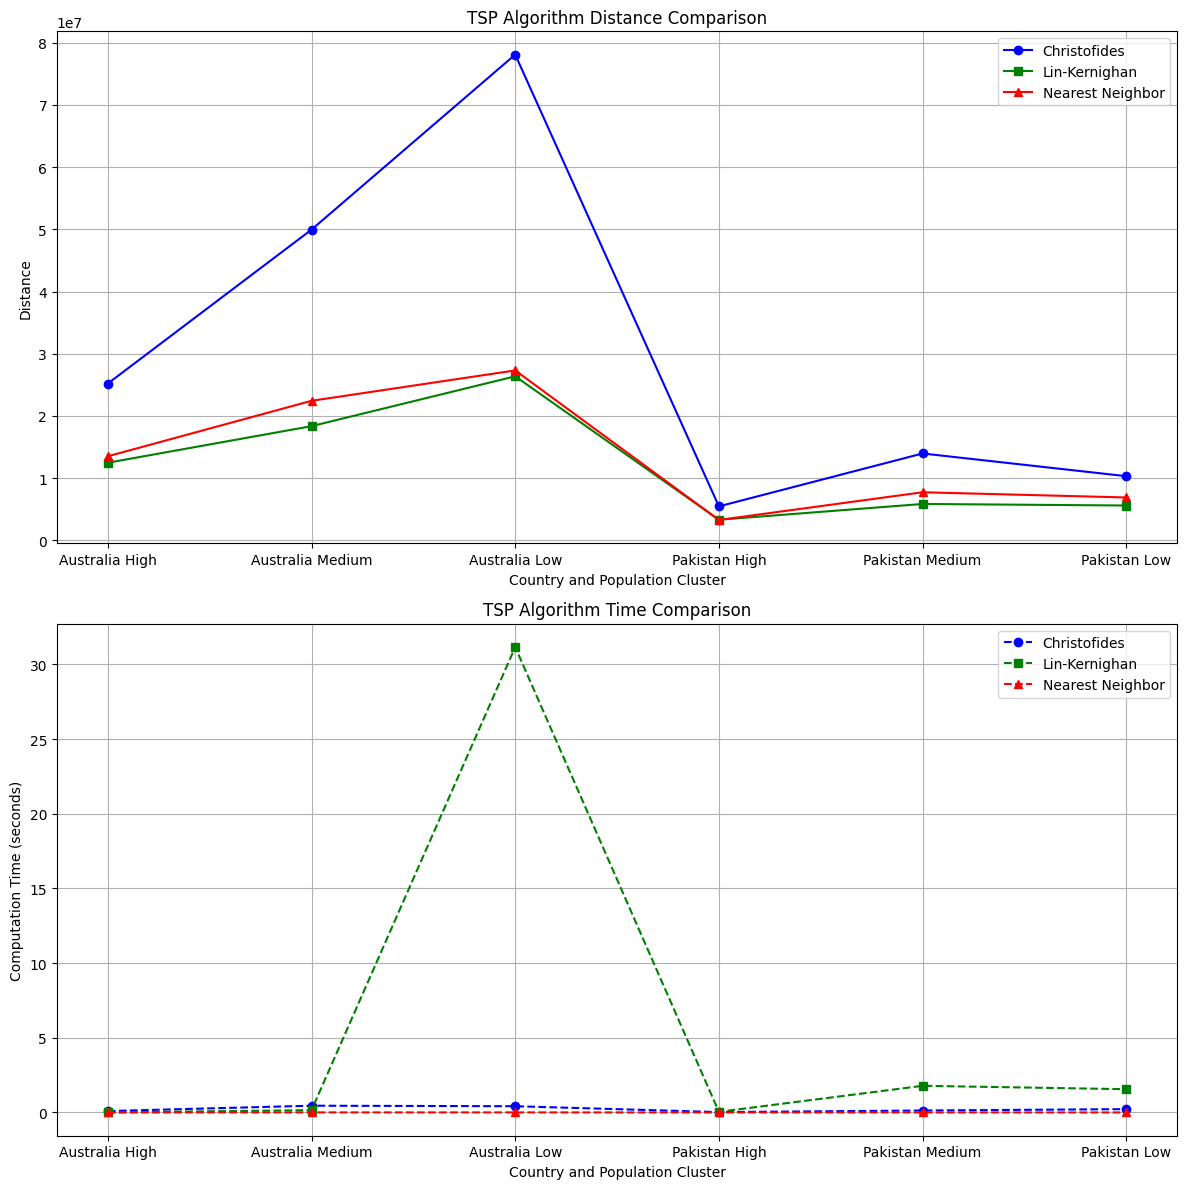

In [503]:
# Data for real-world dataset analysis for Australia and Pakistan
countries_clusters = [
    'Australia High', 'Australia Medium', 'Australia Low',
    'Pakistan High', 'Pakistan Medium', 'Pakistan Low'
]
distances_CH = [
    25198520.43, 49945917.0033081, 78096354.69445576,
    5445386.147144399, 13952674.019575339, 10300384.849921709
]
times_CH = [
    0.0928812026977539, 0.45174694061279197, 0.417501141357422,
    0.02542567253112793, 0.13047361373901367, 0.222991943359375
]

distances_LK = [
    12465409.412453061, 18345761.8760144, 26362573.62841919,
    3298777.3142610085, 5835440.809502282, 5584460.534004124
]
times_LK = [
    0.004068446807861333, 0.15427827835083008, 31.15951354904175,
    0.04314470291137695, 1.7842371463775635, 1.5575568675994873
]

distances_NN = [
    13501231.219921868, 22422375.637012288, 27310998.972326618,
    3262578.9408481633, 7716836.980681908, 6877444.865621893
]
times_NN = [
    0.0005674362182617188, 0.0037374496459960938, 0.0036339759826660156,
    0.00017881393432617188, 0.0012123584747314453, 0.0005657672882080078
]

# Create subplots for the distance and time
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Distance plot
axes[0].plot(countries_clusters, distances_CH, 'o-', label='Christofides', color='blue')
axes[0].plot(countries_clusters, distances_LK, 's-', label='Lin-Kernighan', color='green')
axes[0].plot(countries_clusters, distances_NN, '^-', label='Nearest Neighbor', color='red')
axes[0].set_xlabel('Country and Population Cluster')
axes[0].set_ylabel('Distance')
axes[0].set_title('TSP Algorithm Distance Comparison')
axes[0].legend()
axes[0].grid(True)

# Time plot
axes[1].plot(countries_clusters, times_CH, 'o--', label='Christofides', color='blue')
axes[1].plot(countries_clusters, times_LK, 's--', label='Lin-Kernighan', color='green')
axes[1].plot(countries_clusters, times_NN, '^--', label='Nearest Neighbor', color='red')
axes[1].set_xlabel('Country and Population Cluster')
axes[1].set_ylabel('Computation Time (seconds)')
axes[1].set_title('TSP Algorithm Time Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
